In [641]:
import pandas as pd

# from http://nlp.cs.washington.edu/zeroshot/evaluate.py
import os
import codecs
import re
from itertools import groupby
import string
import sys
import numpy as np

PUNCTUATION = set(string.punctuation)

def eval_zero_re(test_file, answer_file):
    q_aprf = read_results(test_file, answer_file)
    return pretify(q_aprf)

def read_results(test_set, answer_file):
    with codecs.open(test_set, 'r', 'utf-8') as fin:
        data = [line.strip().split('\t') for line in fin]
    metadata = [x[:4] for x in data]
    gold = [set(x[4:]) for x in data]
    
    #new_gold = []
    #for g in gold:
    #    if g:
    #        new_gold.append(g)

    #print(gold)
    
    new_gold = gold  # for including unknowns.

    with codecs.open(answer_file, 'r', 'utf-8') as fin:
        answers = [line.strip() for line in fin]

    new_answers = []
    # ignore the header in answers
    for answer in answers[1:]:
        if answer != 'no_answer':
            new_answers.append(answer)
        else:
            new_answers.append("")

    #print(new_answers)
    telemetry = []
    for m, g, a in zip(metadata, new_gold, new_answers):
        stats = score(g, a)
        telemetry.append([m[0], m[1], str(len(g) > 0), stats])
    return aprf(telemetry)


def parse_no_answers(results):
    p_answer = [a for i, a in sorted([(int(i), a) for i, a in results[0]['scores'].items()])]
    p_no_answer = [a for i, a in sorted([(int(i), a) for i, a in results[0]['na'].items()])]

    import numpy as np
    return [answer > no_answer for answer, no_answer in zip(p_answer, p_no_answer)]


def gb(collection, keyfunc):
    return [(k, list(g)) for k, g in groupby(sorted(collection, key=keyfunc), keyfunc)]


def aprf(g):
    tp, tn, sys_pos, real_pos = sum(map(lambda x: x[-1], g))
    total = len(g)
    # a = float(tp + tn) / total
    # nr = tn / float(total - real_pos)
    # npr = tn / float(total - sys_pos)
    if tp == 0:
        p = r = f = 0.0
    else:
        p = tp / float(sys_pos)
        r = tp / float(real_pos)
        f = 2 * p * r / (p + r)
    # return np.array((a, p, r, f, npr, nr))
    return np.array((p, r, f))


def score(gold, answer):
    if len(gold) > 0:
        gold = set.union(*[simplify(g) for g in gold])
    answer = simplify(answer)
    result = np.zeros(4)
    if answer == gold:
        if len(gold) > 0:
            result[0] += 1
        else:
            result[1] += 1
    if len(answer) > 0:
        result[2] += 1
    if len(gold) > 0:
        result[3] += 1
    return result


def simplify(answer):
    return set(''.join(c for c in t if c not in PUNCTUATION) for t in answer.strip().lower().split()) - {'the', 'a', 'an', 'and', ''}


def pretify(results):
    return ' \t '.join([': '.join((k, v)) for k, v in zip(['Precision', 'Recall', 'F1'], map(lambda r: '{0:.2f}%'.format(r*100), results))])

In [644]:
def preprocess_the_prediction_files(main_path, list_of_files):
    for file in list_of_files:
        df = pd.read_csv(os.path.join(main_path, file), sep=',')
        df["predictions_str"].to_csv(os.path.join("/tmp/", file), sep='\t', header=True, index=False)

def eval_the_prediction_files(list_of_files, gold_file):
    scores = []
    for file in list_of_files:
        precision = eval_zero_re(gold_file, os.path.join("/tmp/", file))
        scores.append(precision)
    return scores
        

In [166]:
# GOLD Predictions
fold_files = ["dev.predictions.0.step.{}.csv".format(100 * i) for i in range(0, 28, 1)]

fold_0_path = "~/august_25_runs/re_gold_qa_models_with_unknowns/fold_0/dev_predictions/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

fold_1_path = "~/august_25_runs/re_gold_qa_models_with_unknowns/fold_1/dev_predictions/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

fold_2_path = "~/august_25_runs/re_gold_qa_models_with_unknowns/fold_2/dev_predictions/"
fold_2_gold_file = "./zero-shot-extraction/relation_splits/dev.2"

#preprocess_the_prediction_files(fold_0_path, fold_files)
#fold_0_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_0_gold_file))


preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

#preprocess_the_prediction_files(fold_2_path, fold_files)
#fold_2_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_2_gold_file))

gold_scores = (fold_1_gold_scores) / 1.0

In [167]:
# Concat Predictions

fold_files = ["dev.predictions.0.step.{}.csv".format(100 * i) for i in range(0, 24, 1)]
fold_0_path = "~/august_25_runs/re_concat_qa_models_with_unknowns/fold_0/dev_predictions/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

fold_1_path = "~/august_25_runs/re_concat_qa_models_with_unknowns/fold_1/dev_predictions/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

fold_2_path = "~/august_25_runs/re_concat_qa_models_with_unknowns/fold_2/dev_predictions/"
fold_2_gold_file = "./zero-shot-extraction/relation_splits/dev.2"

#preprocess_the_prediction_files(fold_0_path, fold_files)
#fold_0_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_0_gold_file))

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

#preprocess_the_prediction_files(fold_2_path, fold_files)
#fold_2_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_2_gold_file))

concat_scores = (fold_1_concat_scores) / 1.0
print(concat_scores)

[31.25 66.67 67.   66.67 67.   67.   66.33 65.   65.   66.67 65.67]


In [168]:
# switch_1 Predictions

fold_files = ["dev.fold_1.step_{}.csv".format(100 * i) for i in range(0, 11, 1)]
fold_1_path = "~/august_25_runs/re_mml_pgg_top_p_iterative_models/switch_1/fold_1/dev_predictions/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_switch_1_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

switch_1_scores = (fold_1_switch_1_scores) / 1.0
print(switch_1_scores)

[51.8  57.33 57.   57.67 59.67 59.67 60.33 58.   59.33 59.   61.  ]


In [159]:
# switch_10 Predictions

fold_files = ["dev.fold_1.step_{}.csv".format(100 * i) for i in range(0, 11, 1)]
fold_1_path = "~/august_25_runs/re_mml_pgg_top_p_iterative_models/switch_10/fold_1/dev_predictions/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_switch_10_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

switch_10_scores = (fold_1_switch_10_scores) / 1.0
print(switch_10_scores)

[51.8  44.67 44.67 47.   41.   35.33 37.67 35.67 39.33 36.   39.67]


In [160]:
# switch_50 Predictions

fold_files = ["dev.fold_1.step_{}.csv".format(100 * i) for i in range(0, 11, 1)]
fold_1_path = "~/august_25_runs/re_mml_pgg_top_p_iterative_models/switch_50/fold_1/dev_predictions/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_switch_50_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

switch_50_scores = (fold_1_switch_50_scores) / 1.0
print(switch_50_scores)

[51.8  48.   53.33 56.33 59.   19.73 31.33 26.67 24.67 25.33 37.33]


In [175]:
# sim_update Predictions

fold_files = ["dev.fold_1.step_{}.csv".format(100 * i) for i in range(0, 11, 1)]
fold_1_path = "~/august_25_runs/re_mml_pgg_top_p_iterative_models/sim_update/fold_1/dev_predictions/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_sim_update_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

sim_update_scores = (fold_1_sim_update_scores) / 1.0
print(sim_update_scores)

[51.8  42.33 54.52 54.67 51.67 54.   50.67 51.67 59.33 59.   61.  ]


In [180]:
# disjoint_update Predictions

fold_files = ["dev.fold_1.step_{}.csv".format(100 * i) for i in range(0, 11, 1)]
fold_1_path = "~/august_25_runs/re_mml_pgg_top_p_iterative_models/disjoint_sim_update/fold_1/dev_predictions/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_disjoint_sim_update_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

disjoint_sim_update_scores = (fold_1_disjoint_sim_update_scores) / 1.0
print(disjoint_sim_update_scores)

[51.8  48.67 49.16 48.49 51.67 44.67 48.83 46.33 48.67 44.33 43.  ]


In [187]:
# sim_1_new_update Predictions

fold_files = ["dev.fold_1.step_{}.csv".format(100 * i) for i in range(0, 10, 1)]
fold_1_path = "~/august_25_runs/re_mml_pgg_top_p_iterative_models/new_switch_1_run/fold_1/dev_predictions/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_new_switch_1_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

new_switch_1_scores = (fold_1_new_switch_1_scores) / 1.0
print(new_switch_1_scores)

[51.8  48.67 48.33 39.   58.33 58.   51.   56.33 54.33 53.67]


ValueError: x and y must have same first dimension, but have shapes (9,) and (11,)

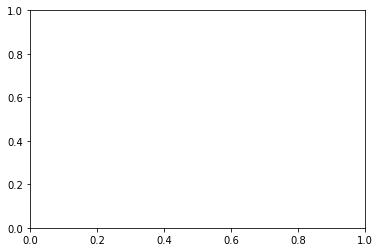

In [189]:
import numpy as np
import matplotlib.pyplot as plt

x = [i * 100 for i in range(0, 9, 1)]

plt.plot(x, gold_scores, 'x--', x, concat_scores, 'o--', x, switch_1_scores, '^--', x, disjoint_sim_update_scores, '*--', x, new_switch_1_scores, 'p--')
plt.show()

In [628]:
# GOLD Predictions
fold_files = ["dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/remote/cirrus-home/snajafi/september_9/re_gold_qa_models_without_unknowns/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

gold_scores = (fold_1_gold_scores) / 1.0
print(gold_scores)
#print(gold_scores[12], 13)

[66.33 68.   68.   65.67 64.67 67.67 65.   67.33 62.   65.   65.33 67.
 70.   65.67 67.   64.67 66.67 63.   66.33]


In [527]:
# Concat Predictions
fold_files = ["dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 17, 1)]

fold_1_path = "/remote/cirrus-home/snajafi/september_9/re_concat_qa_models_without_unknowns/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

concat_scores = (fold_1_concat_scores) / 1.0
print(concat_scores)

[60.33 62.   64.   58.67 62.67 64.67 64.67 63.67 58.33 60.   61.33 61.33
 62.   59.33 61.67 59.  ]


In [413]:
# top p sample using MML-MML using the beam search on the dev set.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 30, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

mml_mml_scores = (fold_1_mml_mml_scores) / 1.0
print(mml_mml_scores)
print(mml_mml_scores[25])

[58.19 53.67 57.   53.67 55.67 50.67 55.   55.   54.   55.33 57.67 55.
 57.33 56.   58.33 58.   57.   56.33 56.33 57.33 54.33 54.33 57.67 57.67
 61.33 59.   56.   55.67 56.  ]
59.0


In [412]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 30, 1)]

fold_1_path = "/home/snajafi/september_9/mml_pgg_top_p/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_pgg_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

length_10_mml_pgg_scores = (fold_1_length_10_mml_pgg_scores) / 1.0
print(length_10_mml_pgg_scores)

[50.   46.82 34.   45.   48.33 51.   48.33 47.33 50.33 48.   56.   51.33
 56.33 47.   46.33 51.67 53.33 55.33 53.67 57.   55.   46.67 52.33 51.
 55.33 52.   50.   52.33 53.  ]


In [403]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.full_beam_length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 25, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_with_blue/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_with_blue_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

length_10_mml_mml_with_blue_scores = (fold_1_length_10_mml_mml_with_blue_scores) / 1.0
print(length_10_mml_mml_with_blue_scores)

[58.   58.67 65.67 57.   23.   24.33 26.33 22.67 25.67 55.33 57.67 55.
 57.33 56.   58.33 58.   57.   56.33 56.33 57.33 54.33 54.33 57.67 57.67]


In [411]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 30, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_answer_only/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_answer_only_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

length_10_mml_mml_answer_only_scores = (fold_1_length_10_mml_mml_answer_only_scores) / 1.0
print(length_10_mml_mml_answer_only_scores)

[52.51 59.33 59.   54.67 58.   60.   62.   54.33 56.   55.   57.67 55.67
 56.67 52.33 55.33 54.33 57.33 52.67 53.33 54.   56.33 56.   53.   56.
 56.   55.   57.19 52.67 55.33]


In [519]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 15, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_v2/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_v2_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

length_10_mml_mml_v2_scores = (fold_1_length_10_mml_mml_v2_scores) / 1.0
print(length_10_mml_mml_v2_scores)

[56.23 60.33 63.   64.   62.67 63.67 58.33 59.67 60.67 58.67 61.33 64.33
 64.67 60.67]


In [460]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 26, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_v2_dropped/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_v2_dropped_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

length_10_mml_mml_v2_dropped_scores = (fold_1_length_10_mml_mml_v2_dropped_scores) / 1.0
print(length_10_mml_mml_v2_dropped_scores)

[54.36 58.67 61.28 63.33 59.67 61.   60.67 64.67 59.33 64.   65.   61.33
 61.33 60.33 58.33 57.   60.   53.   53.67 58.   59.67 55.67 51.33 53.33
 53.  ]


In [468]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 26, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_real_question/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_real_question_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

length_10_mml_mml_real_question_scores = (fold_1_length_10_mml_mml_real_question_scores) / 1.0
print(length_10_mml_mml_real_question_scores)
print(length_10_mml_mml_real_question_scores[12])

[61.49 62.   58.   52.33 51.67 62.67 57.33 59.33 62.33 60.2  60.33 59.87
 65.   60.33 64.67 63.67 64.67 59.67 62.33 60.   60.33 61.   61.67 62.33
 61.33]
65.0


In [498]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 5, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_real_question/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_real_question_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

new_length_10_mml_mml_real_question_scores = (fold_1_length_10_mml_mml_real_question_scores) / 1.0
print(new_length_10_mml_mml_real_question_scores)
print(new_length_10_mml_mml_real_question_scores[16])

[61.15 62.33 58.33 54.  ]


IndexError: index 16 is out of bounds for axis 0 with size 4

In [503]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 25, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_real_question_dropped/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_real_question_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

new_length_10_mml_mml_real_question_scores = (fold_1_length_10_mml_mml_real_question_scores) / 1.0
print(new_length_10_mml_mml_real_question_scores)
print(new_length_10_mml_mml_real_question_scores[5])

[55.44 59.12 57.67 58.33 58.67 61.67 60.67 59.67 61.33 55.85 55.33 59.33
 58.33 61.67 56.   53.85 55.1  58.67 59.06 56.33 54.52 57.05 55.52 59.8 ]
61.67


In [528]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 17, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_enforced/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_enforced_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

new_length_10_mml_mml_enforced_scores = (fold_1_length_10_mml_mml_enforced_scores) / 1.0
print(new_length_10_mml_mml_enforced_scores)
print(new_length_10_mml_mml_enforced_scores[10])

[65.67 64.   64.67 66.   66.   64.67 63.67 62.33 61.67 66.33 69.33 67.67
 63.33 62.33 62.67 62.  ]
69.33


In [531]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 17, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_enforced/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_enforced_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

new_length_10_mml_mml_enforced_scores = (fold_1_length_10_mml_mml_enforced_scores) / 1.0
print(new_length_10_mml_mml_enforced_scores)
print(new_length_10_mml_mml_enforced_scores[10])

[65.67 64.   64.67 66.33 66.   64.67 63.67 62.33 61.67 66.33 69.33 67.67
 63.33 62.33 62.67 62.  ]
69.33


In [537]:
# top sample training using MML-PGG having the beam search with the length penalty 10.0 on the dev set and for question generation.
fold_files = ["dev.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 4, 1)]

fold_1_path = "/home/snajafi/september_9/mml_mml_top_p_long_samples/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_length_10_mml_mml_enforced_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

new_length_10_mml_mml_enforced_scores = (fold_1_length_10_mml_mml_enforced_scores) / 1.0
print(new_length_10_mml_mml_enforced_scores)

[60.   61.33 66.33]


In [629]:
# Gold Questions
fold_files = ["dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/gold/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))
print(fold_1_gold_scores)

[61.33 55.67 63.33 64.   65.67 62.67 65.   65.   59.33 62.67 67.   68.
 68.   64.   64.67 68.   67.   67.   65.  ]


In [630]:
# Concat Questions
fold_files = ["dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/concat/"
fold_1_concat_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_1_concat_file))
print(fold_1_concat_scores)

[58.33 59.06 60.   61.67 60.   60.   60.2  57.33 58.67 60.33 62.54 64.33
 64.   61.33 61.33 54.   56.67 62.67 62.67]


In [586]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.basic_top_p.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 6, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[51.67 58.   60.33 60.33 61.  ]


In [587]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.len_norm_top_p.length_penalty_10.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 6, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[61.67 62.67 61.   64.   57.33]


In [589]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.len_norm_beam_top_k.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 6, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[56.67 58.67 47.   54.   61.  ]


In [590]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.question_only.len_norm_beam_top_k.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 2, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[55.65]


In [591]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.entropy.top_p.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 3, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[60.33 60.33]


In [592]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.with_real_q.entropy.top_p.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 6, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[56.   56.   59.33 62.67 66.33]


In [593]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.long.entropy.top_p.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 3, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[53.33 62.33]


In [594]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.len+beam+top_p.entropy.top_p.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 3, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[63.67 58.67]


In [595]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.no_entropy.top_p.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 3, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[54.67 65.67]


In [596]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.small_entropy.top_p.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 2, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[61.67]


In [599]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.bleu.small_entropy.top_p.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 7, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[51.   64.   54.   65.33 59.67 55.33]


In [602]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 4, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[57. 57. 49.]


In [603]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 4, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[52.33 52.33 51.  ]


In [604]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 5, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[52.76 57.67 59.12 57.67]


In [ ]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.more_bleu.small_entropy.top_p.0.fold_1.step_{}.csv".format(100 * i) for i in range(1, 7, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

In [ ]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 5, 1)]

fold_1_path = "/home/snajafi/september_22/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

In [609]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 12, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[49.   52.   47.33 58.86 61.67 56.67 61.   58.   60.67 58.33 59.  ]


In [627]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["1.dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
epoch_1_fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(epoch_1_fold_1_mml_mml_scores)

[57.53 57.67 59.2  58.   58.33 59.   58.67 60.   55.67 58.   56.86 57.33
 54.67 56.86 53.33 57.67 62.67 55.67 57.67]


In [633]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["1.dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[57.53 57.67 59.2  58.   58.33 59.   58.67 60.   55.67 58.   56.86 57.33
 54.67 56.86 53.33 57.67 62.67 55.67 57.67]


In [637]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["pgg.dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[58.33 62.33 60.33 60.33 56.   57.67 54.   51.   55.   52.   57.   54.85
 57.86 56.86 57.53 51.   57.86 59.53 59.53]


In [638]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["with_greedy.dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 10, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[56.   58.67 53.67 64.   57.   62.67 62.   63.   64.67]


In [639]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 10, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[56.67 51.33 60.67 55.52 59.87 58.53 56.   58.   63.  ]


In [640]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["with_greedy_decoding.dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 10, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

[56.33 57.   54.33 63.   56.19 62.33 62.33 63.33 64.67]


In [652]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["unk_with_greedy.dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

['Precision: 43.81% \t Recall: 33.00% \t F1: 37.64%'
 'Precision: 45.86% \t Recall: 48.00% \t F1: 46.91%'
 'Precision: 41.86% \t Recall: 48.00% \t F1: 44.72%'
 'Precision: 45.25% \t Recall: 54.00% \t F1: 49.24%'
 'Precision: 50.38% \t Recall: 44.00% \t F1: 46.98%'
 'Precision: 42.67% \t Recall: 55.33% \t F1: 48.19%'
 'Precision: 45.90% \t Recall: 50.33% \t F1: 48.01%'
 'Precision: 53.77% \t Recall: 52.33% \t F1: 53.04%'
 'Precision: 42.20% \t Recall: 52.33% \t F1: 46.73%'
 'Precision: 50.48% \t Recall: 53.00% \t F1: 51.71%'
 'Precision: 54.02% \t Recall: 47.00% \t F1: 50.27%'
 'Precision: 44.57% \t Recall: 50.67% \t F1: 47.43%'
 'Precision: 44.18% \t Recall: 43.00% \t F1: 43.58%'
 'Precision: 38.46% \t Recall: 43.33% \t F1: 40.75%'
 'Precision: 49.24% \t Recall: 32.33% \t F1: 39.03%'
 'Precision: 48.00% \t Recall: 44.00% \t F1: 45.91%'
 'Precision: 56.14% \t Recall: 42.67% \t F1: 48.48%'
 'Precision: 52.35% \t Recall: 48.33% \t F1: 50.26%'
 'Precision: 54.96% \t Recall: 44.33% \t F1: 4

In [667]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["1.unk_with_greedy.dev.correct_off_policy.bleu_entropy.fold_1.step_{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/dev.1"
preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

['Precision: 48.43% \t Recall: 41.00% \t F1: 44.40%'
 'Precision: 52.53% \t Recall: 38.00% \t F1: 44.10%'
 'Precision: 46.13% \t Recall: 51.67% \t F1: 48.74%'
 'Precision: 48.84% \t Recall: 49.00% \t F1: 48.92%'
 'Precision: 44.62% \t Recall: 47.00% \t F1: 45.78%'
 'Precision: 48.91% \t Recall: 52.33% \t F1: 50.56%'
 'Precision: 46.25% \t Recall: 51.33% \t F1: 48.66%'
 'Precision: 59.64% \t Recall: 33.00% \t F1: 42.49%'
 'Precision: 51.75% \t Recall: 49.33% \t F1: 50.51%'
 'Precision: 53.29% \t Recall: 51.33% \t F1: 52.29%'
 'Precision: 58.47% \t Recall: 58.67% \t F1: 58.57%'
 'Precision: 53.12% \t Recall: 51.00% \t F1: 52.04%'
 'Precision: 49.23% \t Recall: 53.00% \t F1: 51.04%'
 'Precision: 50.00% \t Recall: 56.00% \t F1: 52.83%'
 'Precision: 47.50% \t Recall: 44.33% \t F1: 45.86%'
 'Precision: 54.00% \t Recall: 45.00% \t F1: 49.09%'
 'Precision: 55.33% \t Recall: 36.33% \t F1: 43.86%'
 'Precision: 53.56% \t Recall: 42.67% \t F1: 47.50%'
 'Precision: 56.30% \t Recall: 47.67% \t F1: 5

In [670]:
# Concat for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["test.predictions.2.step..csv"]
fold_1_path = "/home/snajafi/september_22/concat/"
fold_1_concat_file = "./zero-shot-extraction/relation_splits/test.1"
preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_1_concat_file))
print(fold_1_concat_scores)

['Precision: 55.47% \t Recall: 24.42% \t F1: 33.91%']


In [671]:
# MML-MML for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["1.unk_with_greedy.test.correct_off_policy.bleu_entropy.fold_1.step_1100.csv"]

fold_1_path = "/home/snajafi/september_22/mml_mml_top_p_long_samples/"
fold_1_mml_mml_file = "./zero-shot-extraction/relation_splits/test.1"
preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_mml_mml_scores = np.array(eval_the_prediction_files(fold_files, fold_1_mml_mml_file))
print(fold_1_mml_mml_scores)

['Precision: 45.55% \t Recall: 35.17% \t F1: 39.69%']


In [672]:
# Gold for Question Only Generation with Long Samples and Mix of Squad Questions.
fold_files = ["test.predictions.1.step.800.csv"]

fold_1_path = "/home/snajafi/september_22/gold/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/test.1"
preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))
print(fold_1_gold_scores)

['Precision: 47.69% \t Recall: 38.73% \t F1: 42.75%']


In [658]:
# Gold Questions
fold_files = ["dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/gold/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))
print(fold_1_gold_scores)

['Precision: 49.33% \t Recall: 61.33% \t F1: 54.68%'
 'Precision: 53.20% \t Recall: 63.67% \t F1: 57.97%'
 'Precision: 48.49% \t Recall: 64.33% \t F1: 55.30%'
 'Precision: 51.45% \t Recall: 59.00% \t F1: 54.97%'
 'Precision: 62.44% \t Recall: 42.67% \t F1: 50.69%'
 'Precision: 54.98% \t Recall: 57.00% \t F1: 55.97%'
 'Precision: 55.28% \t Recall: 45.33% \t F1: 49.82%'
 'Precision: 57.43% \t Recall: 47.67% \t F1: 52.09%'
 'Precision: 52.13% \t Recall: 57.00% \t F1: 54.46%'
 'Precision: 52.29% \t Recall: 64.67% \t F1: 57.82%'
 'Precision: 69.27% \t Recall: 47.33% \t F1: 56.24%'
 'Precision: 58.98% \t Recall: 50.33% \t F1: 54.32%'
 'Precision: 63.40% \t Recall: 32.33% \t F1: 42.83%'
 'Precision: 55.11% \t Recall: 50.33% \t F1: 52.61%'
 'Precision: 58.04% \t Recall: 49.33% \t F1: 53.33%'
 'Precision: 52.99% \t Recall: 47.33% \t F1: 50.00%'
 'Precision: 48.93% \t Recall: 61.00% \t F1: 54.30%'
 'Precision: 54.51% \t Recall: 52.33% \t F1: 53.40%'
 'Precision: 55.66% \t Recall: 57.33% \t F1: 5

In [665]:
# Gold Questions
fold_files = ["dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/gold/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))
print(fold_1_gold_scores)

['Precision: 57.41% \t Recall: 60.67% \t F1: 59.00%'
 'Precision: 65.57% \t Recall: 53.33% \t F1: 58.82%'
 'Precision: 59.09% \t Recall: 56.33% \t F1: 57.68%'
 'Precision: 56.62% \t Recall: 61.33% \t F1: 58.88%'
 'Precision: 65.15% \t Recall: 52.33% \t F1: 58.04%'
 'Precision: 60.00% \t Recall: 54.00% \t F1: 56.84%'
 'Precision: 63.12% \t Recall: 55.33% \t F1: 58.97%'
 'Precision: 61.32% \t Recall: 58.67% \t F1: 59.97%'
 'Precision: 64.90% \t Recall: 53.00% \t F1: 58.35%'
 'Precision: 52.47% \t Recall: 56.67% \t F1: 54.49%'
 'Precision: 53.07% \t Recall: 57.67% \t F1: 55.27%'
 'Precision: 59.43% \t Recall: 48.33% \t F1: 53.31%'
 'Precision: 56.38% \t Recall: 53.00% \t F1: 54.64%'
 'Precision: 55.48% \t Recall: 54.00% \t F1: 54.73%'
 'Precision: 60.61% \t Recall: 53.33% \t F1: 56.74%'
 'Precision: 58.89% \t Recall: 53.00% \t F1: 55.79%'
 'Precision: 62.83% \t Recall: 47.33% \t F1: 53.99%'
 'Precision: 54.13% \t Recall: 59.00% \t F1: 56.46%'
 'Precision: 54.40% \t Recall: 57.67% \t F1: 5

In [ ]:
# Gold Questions
fold_files = ["dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/gold/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))
print(fold_1_gold_scores)

In [663]:
# Concat Questions
fold_files = ["dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/concat/"
fold_1_concat_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_1_concat_file))
print(fold_1_concat_scores)

['Precision: 52.27% \t Recall: 53.67% \t F1: 52.96%'
 'Precision: 53.06% \t Recall: 52.00% \t F1: 52.53%'
 'Precision: 50.00% \t Recall: 58.33% \t F1: 53.85%'
 'Precision: 48.30% \t Recall: 56.67% \t F1: 52.15%'
 'Precision: 64.71% \t Recall: 36.67% \t F1: 46.81%'
 'Precision: 49.45% \t Recall: 59.67% \t F1: 54.08%'
 'Precision: 61.84% \t Recall: 42.67% \t F1: 50.49%'
 'Precision: 58.37% \t Recall: 43.00% \t F1: 49.52%'
 'Precision: 45.97% \t Recall: 45.67% \t F1: 45.82%'
 'Precision: 46.87% \t Recall: 52.33% \t F1: 49.45%'
 'Precision: 54.31% \t Recall: 48.33% \t F1: 51.15%'
 'Precision: 46.40% \t Recall: 43.00% \t F1: 44.64%'
 'Precision: 60.26% \t Recall: 15.67% \t F1: 24.87%'
 'Precision: 48.44% \t Recall: 51.67% \t F1: 50.00%'
 'Precision: 57.41% \t Recall: 41.33% \t F1: 48.06%'
 'Precision: 60.92% \t Recall: 35.33% \t F1: 44.73%'
 'Precision: 48.46% \t Recall: 47.33% \t F1: 47.89%'
 'Precision: 56.72% \t Recall: 50.67% \t F1: 53.52%'
 'Precision: 49.22% \t Recall: 52.67% \t F1: 5

In [666]:
# Concat Questions
fold_files = ["dev.predictions.2.step.{}.csv".format(100 * i) for i in range(1, 20, 1)]

fold_1_path = "/home/snajafi/september_22/concat/"
fold_1_concat_file = "./zero-shot-extraction/relation_splits/dev.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_1_concat_file))
print(fold_1_concat_scores)

['Precision: 53.42% \t Recall: 54.67% \t F1: 54.04%'
 'Precision: 51.10% \t Recall: 54.33% \t F1: 52.67%'
 'Precision: 56.61% \t Recall: 55.67% \t F1: 56.13%'
 'Precision: 49.84% \t Recall: 52.33% \t F1: 51.06%'
 'Precision: 66.15% \t Recall: 42.33% \t F1: 51.63%'
 'Precision: 50.15% \t Recall: 54.67% \t F1: 52.31%'
 'Precision: 68.84% \t Recall: 49.33% \t F1: 57.48%'
 'Precision: 49.86% \t Recall: 58.00% \t F1: 53.62%'
 'Precision: 52.33% \t Recall: 52.33% \t F1: 52.33%'
 'Precision: 51.56% \t Recall: 49.67% \t F1: 50.59%'
 'Precision: 52.26% \t Recall: 54.00% \t F1: 53.11%'
 'Precision: 56.40% \t Recall: 47.00% \t F1: 51.27%'
 'Precision: 52.79% \t Recall: 41.00% \t F1: 46.15%'
 'Precision: 60.70% \t Recall: 46.33% \t F1: 52.55%'
 'Precision: 64.36% \t Recall: 43.33% \t F1: 51.79%'
 'Precision: 58.47% \t Recall: 48.33% \t F1: 52.92%'
 'Precision: 51.03% \t Recall: 49.33% \t F1: 50.17%'
 'Precision: 51.38% \t Recall: 56.00% \t F1: 53.59%'
 'Precision: 47.43% \t Recall: 52.33% \t F1: 4

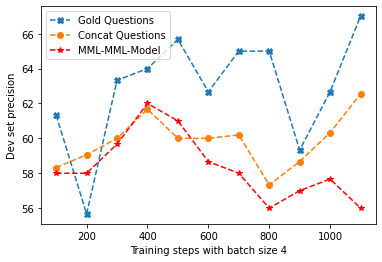

In [614]:
import numpy as np
import matplotlib.pyplot as plt

x = [i * 100 for i in range(1, 20, 1)]

plt.plot(x, fold_1_gold_scores, 'X--', label="Gold Questions")
#plt.plot(x, fold_1_concat_scores, 'o--', label="Concat Questions")
plt.plot(x, fold_1_mml_mml_scores, '*--', label="MML-MML-Model", color='red')
plt.legend()
plt.ylabel('Dev set F1')
plt.xlabel('Training steps with batch size 2')
plt.show()

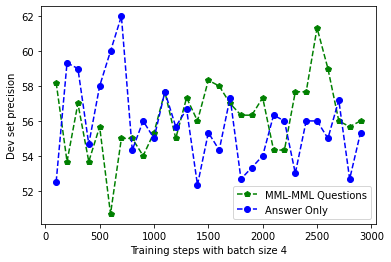

In [415]:
import numpy as np
import matplotlib.pyplot as plt

x = [i * 100 for i in range(1, 30, 1)]

#plt.plot(x, gold_scores, 'X--', label="Gold Questions")
#plt.plot(x, concat_scores, 'o--', label="Concat Questions")
plt.plot(x, mml_mml_scores, 'p--', label="MML-MML Questions", color='green')
#plt.plot(x, length_10_mml_pgg_scores, '*--', label="MML-PGG Questions", color='red')
plt.plot(x, length_10_mml_mml_answer_only_scores, 'o--', label="Answer Only", color='blue')
plt.legend()
plt.ylabel('Dev set precision')
plt.xlabel('Training steps with batch size 4')
plt.show()

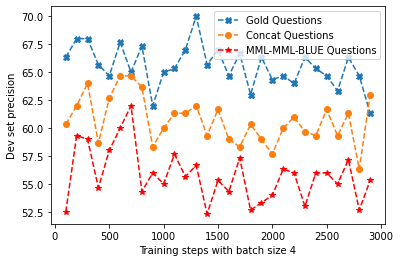

In [416]:
import numpy as np
import matplotlib.pyplot as plt

x = [i * 100 for i in range(1, 30, 1)]

plt.plot(x, gold_scores[1:30], 'X--', label="Gold Questions")
plt.plot(x, concat_scores[1:30], 'o--', label="Concat Questions")
#plt.plot(x, mml_mml_scores[1:30], 'p--', label="MML-MML Questions", color='green')
plt.plot(x, length_10_mml_mml_answer_only_scores, '*--', label="MML-MML-BLUE Questions", color='red')
plt.legend()
plt.ylabel('Dev set precision')
plt.xlabel('Training steps with batch size 4')
plt.show()

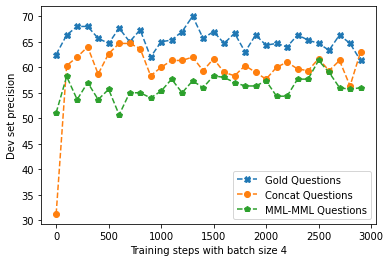

In [397]:
import numpy as np
import matplotlib.pyplot as plt

x = [i * 100 for i in range(0, 30, 1)]

plt.plot(x, gold_scores, 'X--', label="Gold Questions")
plt.plot(x, concat_scores, 'o--', label="Concat Questions")
plt.plot(x, mml_mml_scores, 'p--', label="MML-MML Questions")
plt.legend()
plt.ylabel('Dev set precision')
plt.xlabel('Training steps with batch size 4')
plt.show()

In [322]:
# Test GOLD Predictions
fold_files = ["test.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 29, 1)]

fold_1_path = "/remote/cirrus-home/snajafi/september_9/re_gold_qa_models_without_unknowns/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/test.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_gold_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

gold_scores = (fold_1_gold_scores) / 1.0
print(gold_scores[12])

53.28


In [323]:
# Concat Predictions
fold_files = ["test.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 29, 1)]

fold_1_path = "/remote/cirrus-home/snajafi/september_9/re_concat_qa_models_without_unknowns/fold_1/"
fold_1_gold_file = "./zero-shot-extraction/relation_splits/test.1"

preprocess_the_prediction_files(fold_1_path, fold_files)
fold_1_concat_scores = np.array(eval_the_prediction_files(fold_files, fold_1_gold_file))

concat_scores = (fold_1_concat_scores) / 1.0
print(concat_scores[5])

58.95


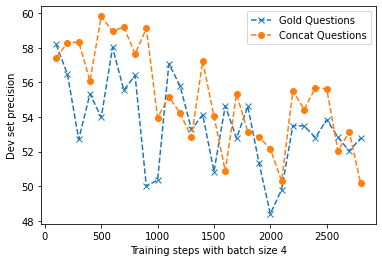

In [321]:
import numpy as np
import matplotlib.pyplot as plt

x = [i * 100 for i in range(1, 29, 1)]

plt.plot(x, gold_scores, 'x--', label="Gold Questions")
plt.plot(x, concat_scores, 'o--', label="Concat Questions")
#plt.plot(x, length_10_mml_mml_scores, 'p--', label="MML-MML Questions")
plt.legend()
plt.ylabel('Dev set precision')
plt.xlabel('Training steps with batch size 4')
plt.show()